# import required libraries

In [5]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score, silhouette_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns


# Load the datasets


In [8]:
customers = pd.read_csv(r"C:\Users\kanak\Downloads\Customers.csv")
products = pd.read_csv(r"C:\Users\kanak\Downloads\Products.csv")
transactions = pd.read_csv(r"C:\Users\kanak\Downloads\Transactions.csv")

# Merge dataframes to get complete transaction details


In [11]:
merged = transactions.merge(customers, on="CustomerID", how="inner")


# Feature Engineering
### Total spending per customer

In [14]:
total_spent = merged.groupby("CustomerID")["TotalValue"].sum().reset_index()
total_spent.columns = ["CustomerID", "TotalSpent"]


# Transaction frequency per customer

In [17]:
frequency = merged.groupby("CustomerID")["TransactionID"].count().reset_index()
frequency.columns = ["CustomerID", "TransactionFrequency"]



# Average transaction value per customer


In [20]:
avg_transaction_value = merged.groupby("CustomerID")["TotalValue"].mean().reset_index()
avg_transaction_value.columns = ["CustomerID", "AvgTransactionValue"]

 # Days since last transaction


In [23]:
merged["TransactionDate"] = pd.to_datetime(merged["TransactionDate"])
last_transaction = merged.groupby("CustomerID")["TransactionDate"].max().reset_index()
last_transaction["DaysSinceLastTransaction"] = (merged["TransactionDate"].max() - last_transaction["TransactionDate"]).dt.days
last_transaction = last_transaction[["CustomerID", "DaysSinceLastTransaction"]]



# Region encoding


In [26]:
le = LabelEncoder()
customers["RegionEncoded"] = le.fit_transform(customers["Region"])


# Combine all features

In [31]:
features = total_spent.merge(frequency, on="CustomerID")
features = features.merge(avg_transaction_value, on="CustomerID")
features = features.merge(last_transaction, on="CustomerID")
features = features.merge(customers[["CustomerID", "RegionEncoded"]], on="CustomerID")


# Drop CustomerID for clustering

In [34]:
features = features.drop("CustomerID", axis=1)


# Standardize the features


In [37]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)



# Clustering


In [40]:
cluster_metrics = []

for n_clusters in range(2, 11):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(scaled_features)


C:\Users\kanak\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\kanak\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "C:\Users\kanak\anaconda3\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\kanak\anaconda3\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "C:\Users\kanak\anaconda3\Lib\subprocess.py", line 1538, in _execute_child
    hp, ht, pid, tid = _winapi.CreatePro

 # Calculate metrics


In [45]:
db_index = davies_bouldin_score(scaled_features, cluster_labels)
silhouette_avg = silhouette_score(scaled_features, cluster_labels)
cluster_metrics.append((n_clusters, db_index, silhouette_avg))


# Convert metrics to DataFrame


In [48]:
metrics_df = pd.DataFrame(cluster_metrics, columns=["NumClusters", "DBIndex", "SilhouetteScore"])


# Find the best number of clusters based on DB Index


C:\Users\kanak\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


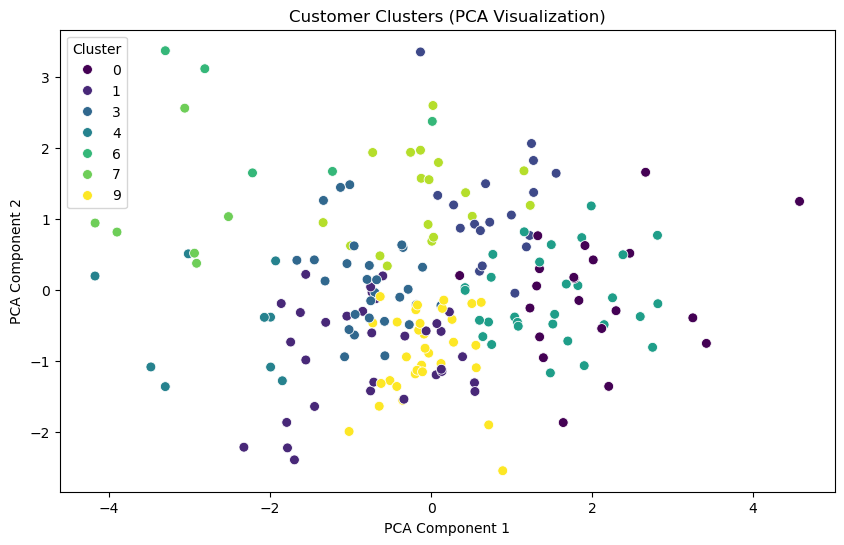

In [51]:
best_n_clusters = metrics_df.loc[metrics_df["DBIndex"].idxmin(), "NumClusters"]

# Fit K-Means with the best number of clusters
final_kmeans = KMeans(n_clusters=int(best_n_clusters), random_state=42)
final_labels = final_kmeans.fit_predict(scaled_features)

# Add cluster labels to the original features
df_with_clusters = features.copy()
df_with_clusters["Cluster"] = final_labels

# Visualization using PCA
pca = PCA(n_components=2)
pca_features = pca.fit_transform(scaled_features)

plt.figure(figsize=(10, 6))
sns.scatterplot(x=pca_features[:, 0], y=pca_features[:, 1], hue=final_labels, palette="viridis", s=50)
plt.title("Customer Clusters (PCA Visualization)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title="Cluster")
plt.show()



# Output metrics


In [54]:
print("Clustering Metrics:")
print(metrics_df)
print(f"\nBest Number of Clusters: {best_n_clusters}")
print(f"Davies-Bouldin Index for Best Clusters: {metrics_df.loc[metrics_df['NumClusters'] == best_n_clusters, 'DBIndex'].values[0]}")

Clustering Metrics:
   NumClusters   DBIndex  SilhouetteScore
0           10  1.248022         0.219577

Best Number of Clusters: 10
Davies-Bouldin Index for Best Clusters: 1.2480222543163362
